# Get the rendered image as numpy array
A quick example on how to render a scene and read back the pixel.

In [1]:
import ipywebgl
import numpy as np

# prepare the scene as usual

w = ipywebgl.GLViewer()
w.clear_color(.8, .8, .8 ,1)
w.clear()
w.enable(depth_test=True)
w.execute_commands(execute_once=True)


axis_prog = w.create_program_ext(
'''#version 300 es
    //the ViewBlock that is automatically filled by ipywebgl
    layout(std140) uniform ViewBlock
    {
        mat4 u_cameraMatrix;          //the camera matrix in world space
        mat4 u_viewMatrix;            //the inverse of the camera matrix
        mat4 u_projectionMatrix;      //the projection matrix
        mat4 u_viewProjectionMatrix;  //the projection * view matrix
    };

    uniform float u_scale;
    in vec3 in_vert;
    in vec3 in_color;
    out vec3 v_color;    
    void main() {
        gl_Position = u_viewProjectionMatrix * vec4(in_vert * u_scale, 1.0);
        v_color = in_color;
    }
''',
'''#version 300 es
    precision highp float;
    in vec3 v_color;
    out vec4 f_color;
    void main() {
        f_color = vec4(v_color, 1.0);
    }
''')

axis_vbo = w.create_buffer_ext(
    src_data= np.array([
            # x, y ,z red, green, blue
            0, 0, 0, 1, 0, 0,
            5, 0, 0, 1, 0, 0,
            0, 0, 0, 0, 1, 0,
            0, 5, 0, 0, 1, 0,
            0, 0, 0, 0, 0, 1,
            0, 0, 5, 0, 0, 1,
        ], dtype=np.float32)
)

axis_vao = w.create_vertex_array_ext(
    axis_prog,
    [
        (axis_vbo, '3f32 3f32', 'in_vert', 'in_color'),
    ]
)

# from here we can request to sync the rendering with the image_data
w.sync_image_data = True

w.clear()
w.use_program(axis_prog)
w.uniform('u_scale', np.array([10.0], dtype=np.float32))
w.bind_vertex_array(axis_vao)
w.draw_arrays('LINES', 0, 6)

# render
w.execute_commands(execute_once=True)

    
# we do not need to display the widgets, but we need to execute this cell first before getting the result


## Read the image data

To read the image data we need to execute the previous cell.  
Only when the previous cell has been executed and the control has been given back to Jupyter can we execute the next cell

(480, 640, 4)

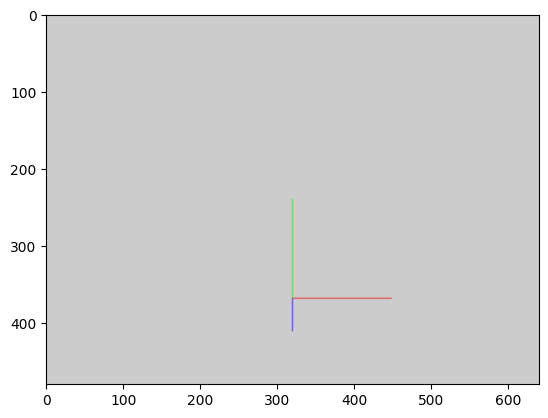

In [2]:
from matplotlib import pyplot as plt

img = w.get_image_data()

display(img.shape)
plt.imshow(img)

## Execute in a loop

To execute in a loop we need to do it inside a ipywidget like a PlayWidget. So every frame the image_data is updated.  

<b>Warning :</b> you cannot get the image you just computed, you can only get the image computed the previous frame.  
If we try to execute this inside a normal python loop, the control is not given back to python and the image_data is not updated.

In [3]:
from ipywidgets import widgets, interact, Output

w.sync_image_data = True

def render(p):

    # get image (from the previous frame)
    if p > 0:
        plt.imshow(w.get_image_data())
        plt.title(f'Frame: {p-1}')
        plt.show()
    
    w.clear_color(p/50, .8, .8 ,1)
    w.clear()
    w.use_program(axis_prog)
    w.uniform('u_scale', np.array([p+1], dtype=np.float32))
    w.bind_vertex_array(axis_vao)
    w.draw_arrays('LINES', 0, 6)

    # render
    w.execute_commands(execute_once=True)
    
play = widgets.Play(
    value=0,
    min=0,
    max=50,
    step=1,
    interval=50,
    description="play",
    disabled=False
)

interact(render, p=play)


interactive(children=(Play(value=0, description='play', interval=50, max=50), Output()), _dom_classes=('widget…

<function __main__.render(p)>

## Using observer to get the result in the same cell

If you want to get the result of the computed value directly in the same cell, you can use the observer method.

<b>Warning :</b> even with this method you need to use a PlayWidget, as a normal loop will not execute the observer neither.

In [4]:
#create an output to display async data
out = Output()

# add an observer to the widget
def get_image(change):
    img = w.get_image_data()
    
    # do what you want with it
    with out:
        display(('read image_data :', img.shape))
    

# Listen to changes on the image_data and get_image when it changes.
w.observe(get_image, "image_data")

# execute rendering
w.clear_color(.8, .8, .8 ,1)
w.clear()
w.use_program(axis_prog)
w.uniform('u_scale', np.array([10], dtype=np.float32))
w.bind_vertex_array(axis_vao)
w.draw_arrays('LINES', 0, 6)

# render
w.execute_commands(execute_once=True)

#display output
out

Output()

### Remove the observer

In [5]:
w.unobserve(get_image, "image_data")